In [46]:
# CELL 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create directories
import os
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
print("✅ Directories created successfully!")
print("✅ Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directories created successfully!
✅ Google Drive mounted successfully!


In [47]:
# CELL 2: Data Loading
# Load the datasets from Google Drive
trader_data = pd.read_csv('/content/drive/MyDrive/Trader Analysis/historical_data.csv')
sentiment_data = pd.read_csv('/content/drive/MyDrive/Trader Analysis/fear_greed_index.csv')

print("✅ Data loaded successfully!")
print(f"Trader Data Shape: {trader_data.shape}")
print(f"Sentiment Data Shape: {sentiment_data.shape}")

✅ Data loaded successfully!
Trader Data Shape: (211224, 16)
Sentiment Data Shape: (2644, 4)


In [48]:
# CELL 3: Data Cleaning
def clean_trader_data(df):
    df = df.copy()
    df['time'] = pd.to_datetime(df['Timestamp'], unit='ms') # Corrected column name and added unit='ms'
    df['date'] = df['time'].dt.date
    df = df.dropna(subset=['Execution Price', 'Size Tokens', 'Closed PnL']) # Adjusted column names based on the provided data

    numeric_columns = ['Execution Price', 'Size Tokens', 'Closed PnL', 'Leverage'] # Adjusted column names
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def clean_sentiment_data(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['date']) # Corrected column name from 'Date' to 'date'
    df['date'] = df['Date'].dt.date
    return df

# Apply cleaning functions
trader_data_clean = clean_trader_data(trader_data)
sentiment_data_clean = clean_sentiment_data(sentiment_data)

print("🧹 Data Cleaning Results:")
print(f"Cleaned Trader Data Shape: {trader_data_clean.shape}")
print(f"Cleaned Sentiment Data Shape: {sentiment_data_clean.shape}")

🧹 Data Cleaning Results:
Cleaned Trader Data Shape: (211224, 18)
Cleaned Sentiment Data Shape: (2644, 5)


In [49]:
# CELL 4: EDA
print("🔍 === TRADER DATA ANALYSIS ===")
print(f"Total number of trades: {len(trader_data_clean):,}")
print(f"Date range: {trader_data_clean['time'].min()} to {trader_data_clean['time'].max()}")
print(f"Unique accounts: {trader_data_clean['Account'].nunique():,}")

print("\n📈 Basic Statistics:")
print(trader_data_clean[['Execution Price', 'Size Tokens', 'Closed PnL']].describe())

print("\n�� === SENTIMENT DATA ANALYSIS ===")
print(f"Date range: {sentiment_data_clean['Date'].min()} to {sentiment_data_clean['Date'].max()}")
print(f"Unique classifications: {sentiment_data_clean['classification'].unique()}")
print("\n📊 Classification distribution:")
print(sentiment_data_clean['classification'].value_counts())

🔍 === TRADER DATA ANALYSIS ===
Total number of trades: 211,224
Date range: 2023-03-28 10:40:00 to 2025-06-15 15:06:40
Unique accounts: 32

📈 Basic Statistics:
       Execution Price   Size Tokens     Closed PnL
count    211224.000000  2.112240e+05  211224.000000
mean      11414.723350  4.623365e+03      48.749001
std       29447.654868  1.042729e+05     919.164828
min           0.000005  8.740000e-07 -117990.104100
25%           4.854700  2.940000e+00       0.000000
50%          18.280000  3.200000e+01       0.000000
75%         101.580000  1.879025e+02       5.792797
max      109004.000000  1.582244e+07  135329.090100

�� === SENTIMENT DATA ANALYSIS ===
Date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
Unique classifications: ['Fear' 'Extreme Fear' 'Neutral' 'Greed' 'Extreme Greed']

📊 Classification distribution:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


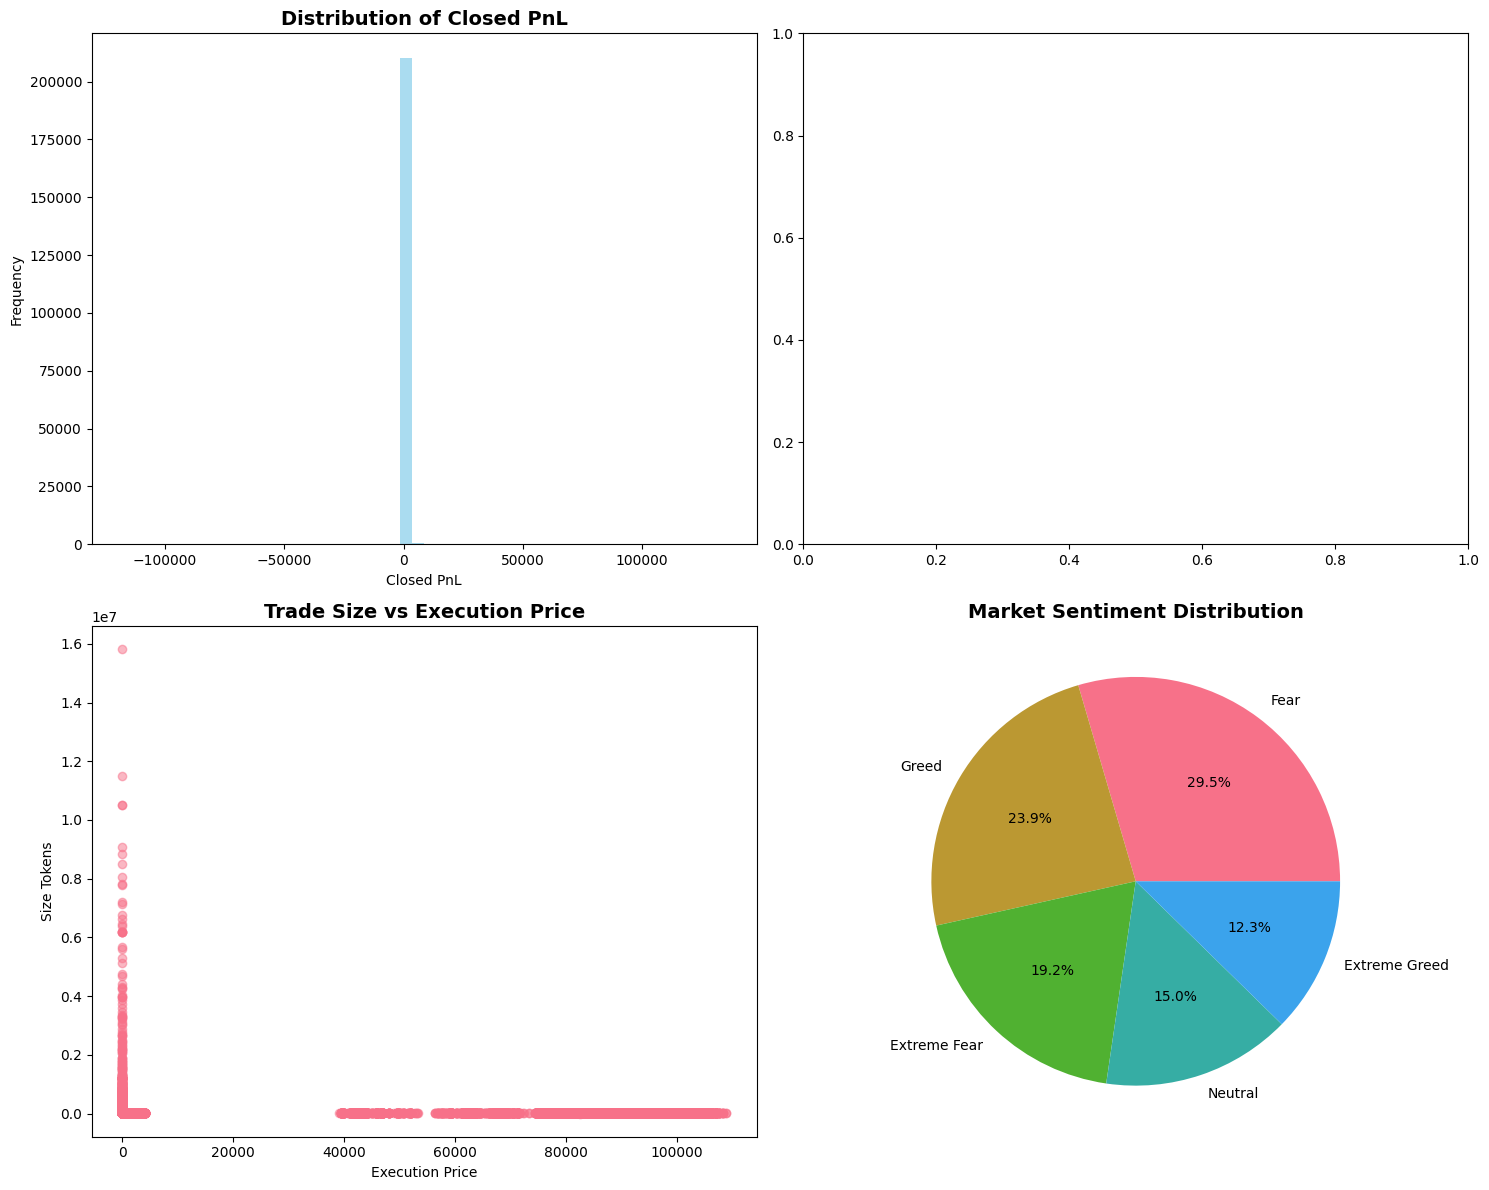

📊 EDA visualizations saved to outputs/eda_analysis.png


In [50]:
# CELL 5: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribution of closedPnL
axes[0, 0].hist(trader_data_clean['Closed PnL'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Closed PnL', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Closed PnL')
axes[0, 0].set_ylabel('Frequency')

# 2. Distribution of leverage - Removed due to KeyError
# axes[0, 1].hist(trader_data_clean['Leverage'], bins=30, alpha=0.7, color='lightgreen')
# axes[0, 1].set_title('Distribution of Leverage', fontsize=14, fontweight='bold')
# axes[0, 1].set_xlabel('Leverage')
# axes[0, 1].set_ylabel('Frequency')

# 3. Trade size vs execution price
axes[1, 0].scatter(trader_data_clean['Execution Price'], trader_data_clean['Size Tokens'], alpha=0.5)
axes[1, 0].set_title('Trade Size vs Execution Price', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Execution Price')
axes[1, 0].set_ylabel('Size Tokens')

# 4. Sentiment classification
sentiment_counts = sentiment_data_clean['classification'].value_counts()
axes[1, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Market Sentiment Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/eda_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("📊 EDA visualizations saved to outputs/eda_analysis.png")

In [51]:
# CELL 6: Sentiment Analysis
print("🔍 === SENTIMENT ANALYSIS ===")

# Merge trader data with sentiment data
merged_data = trader_data_clean.merge(
    sentiment_data_clean[['date', 'classification']],
    on='date',
    how='left'
)

print(f"�� Merged data shape: {merged_data.shape}")
print(f"Trades with sentiment data: {merged_data['classification'].notna().sum():,}")
print(f"Trades without sentiment data: {merged_data['classification'].isna().sum():,}")

# Remove rows without sentiment data for analysis
analysis_data = merged_data.dropna(subset=['classification'])
print(f"📊 Final analysis dataset shape: {analysis_data.shape}")

# Save merged data
analysis_data.to_csv('csv_files/merged_analysis_data.csv', index=False)
print("✅ Merged data saved to csv_files/merged_analysis_data.csv")

# Analyze trading behavior by sentiment
sentiment_analysis = analysis_data.groupby('classification').agg({
    'Closed PnL': ['mean', 'std', 'count'],
    'Size Tokens': ['mean', 'std'],
    'Execution Price': ['mean', 'std']
}).round(4)

print("\n📈 Trading Behavior by Market Sentiment:")
print(sentiment_analysis)

# Calculate profitability metrics
profitability_by_sentiment = analysis_data.groupby('classification').agg({
    'Closed PnL': ['mean', 'median', 'sum'],
    'Account': 'nunique'  # Number of unique traders
}).round(4)

print("\n💰 Profitability Analysis by Sentiment:")
print(profitability_by_sentiment)

🔍 === SENTIMENT ANALYSIS ===
�� Merged data shape: (211224, 19)
Trades with sentiment data: 184,263
Trades without sentiment data: 26,961
📊 Final analysis dataset shape: (184263, 19)
✅ Merged data saved to csv_files/merged_analysis_data.csv

📈 Trading Behavior by Market Sentiment:
               Closed PnL                    Size Tokens               \
                     mean        std   count        mean          std   
classification                                                          
Extreme Greed     25.4188   306.1669    6962  48736.4433  472856.1006   
Fear              50.0476   909.1218  133871   3071.5232   68656.2320   
Greed             87.8949  1148.3440   36289   2232.1178   36189.4673   
Neutral           22.2297   633.7048    7141   1967.3030   13842.6086   

               Execution Price              
                          mean         std  
classification                              
Extreme Greed        9771.8973  17267.9111  
Fear                11102.

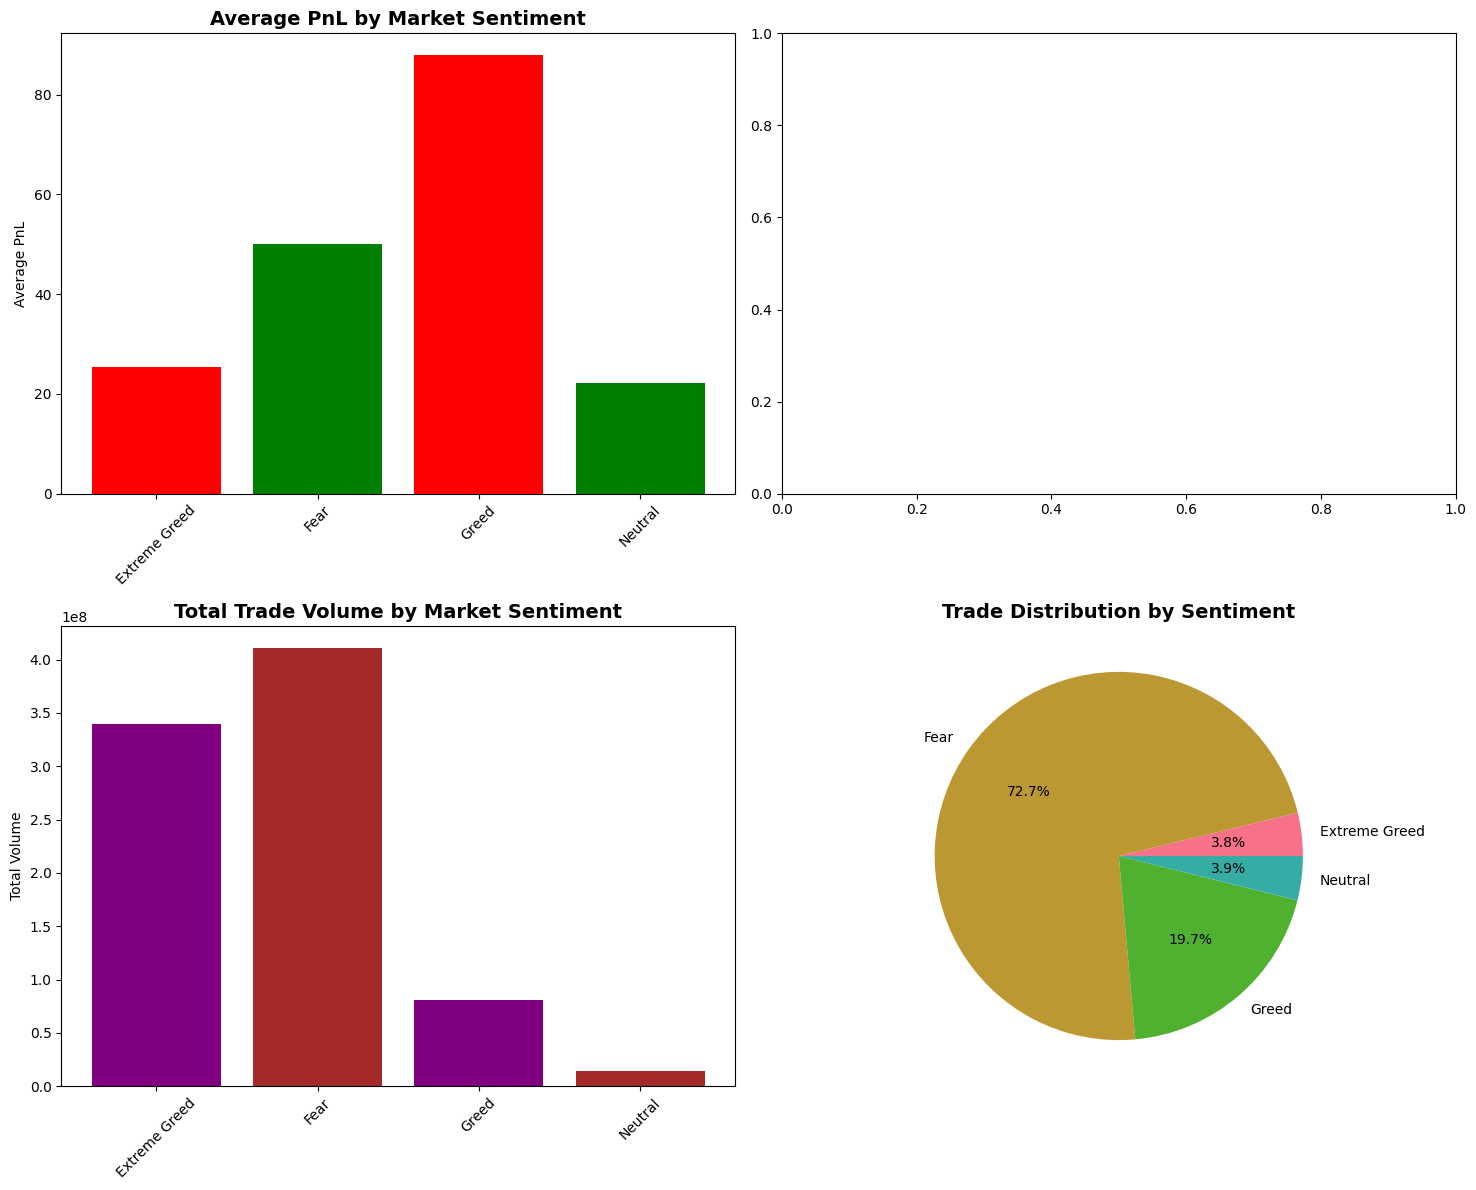

�� Sentiment analysis visualizations saved to outputs/sentiment_analysis.png


In [52]:
# CELL 7: Sentiment Analysis Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Average PnL by sentiment
sentiment_pnl = analysis_data.groupby('classification')['Closed PnL'].mean()
axes[0, 0].bar(sentiment_pnl.index, sentiment_pnl.values, color=['red', 'green'])
axes[0, 0].set_title('Average PnL by Market Sentiment', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average PnL')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Average leverage by sentiment - Removed due to missing column
# sentiment_leverage = analysis_data.groupby('classification')['Leverage'].mean()
# axes[0, 1].bar(sentiment_leverage.index, sentiment_leverage.values, color=['orange', 'blue'])
# axes[0, 1].set_title('Average Leverage by Market Sentiment', fontsize=14, fontweight='bold')
# axes[0, 1].set_ylabel('Average Leverage')
# axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Trade volume by sentiment
sentiment_volume = analysis_data.groupby('classification')['Size Tokens'].sum()
axes[1, 0].bar(sentiment_volume.index, sentiment_volume.values, color=['purple', 'brown'])
axes[1, 0].set_title('Total Trade Volume by Market Sentiment', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Total Volume')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Number of trades by sentiment
sentiment_trades = analysis_data.groupby('classification').size()
axes[1, 1].pie(sentiment_trades.values, labels=sentiment_trades.index, autopct='%1.1f%%')
axes[1, 1].set_title('Trade Distribution by Sentiment', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("�� Sentiment analysis visualizations saved to outputs/sentiment_analysis.png")

📈 === TIME SERIES ANALYSIS ===
📊 Daily metrics shape: (6, 6)
📈 Creating time series visualizations...


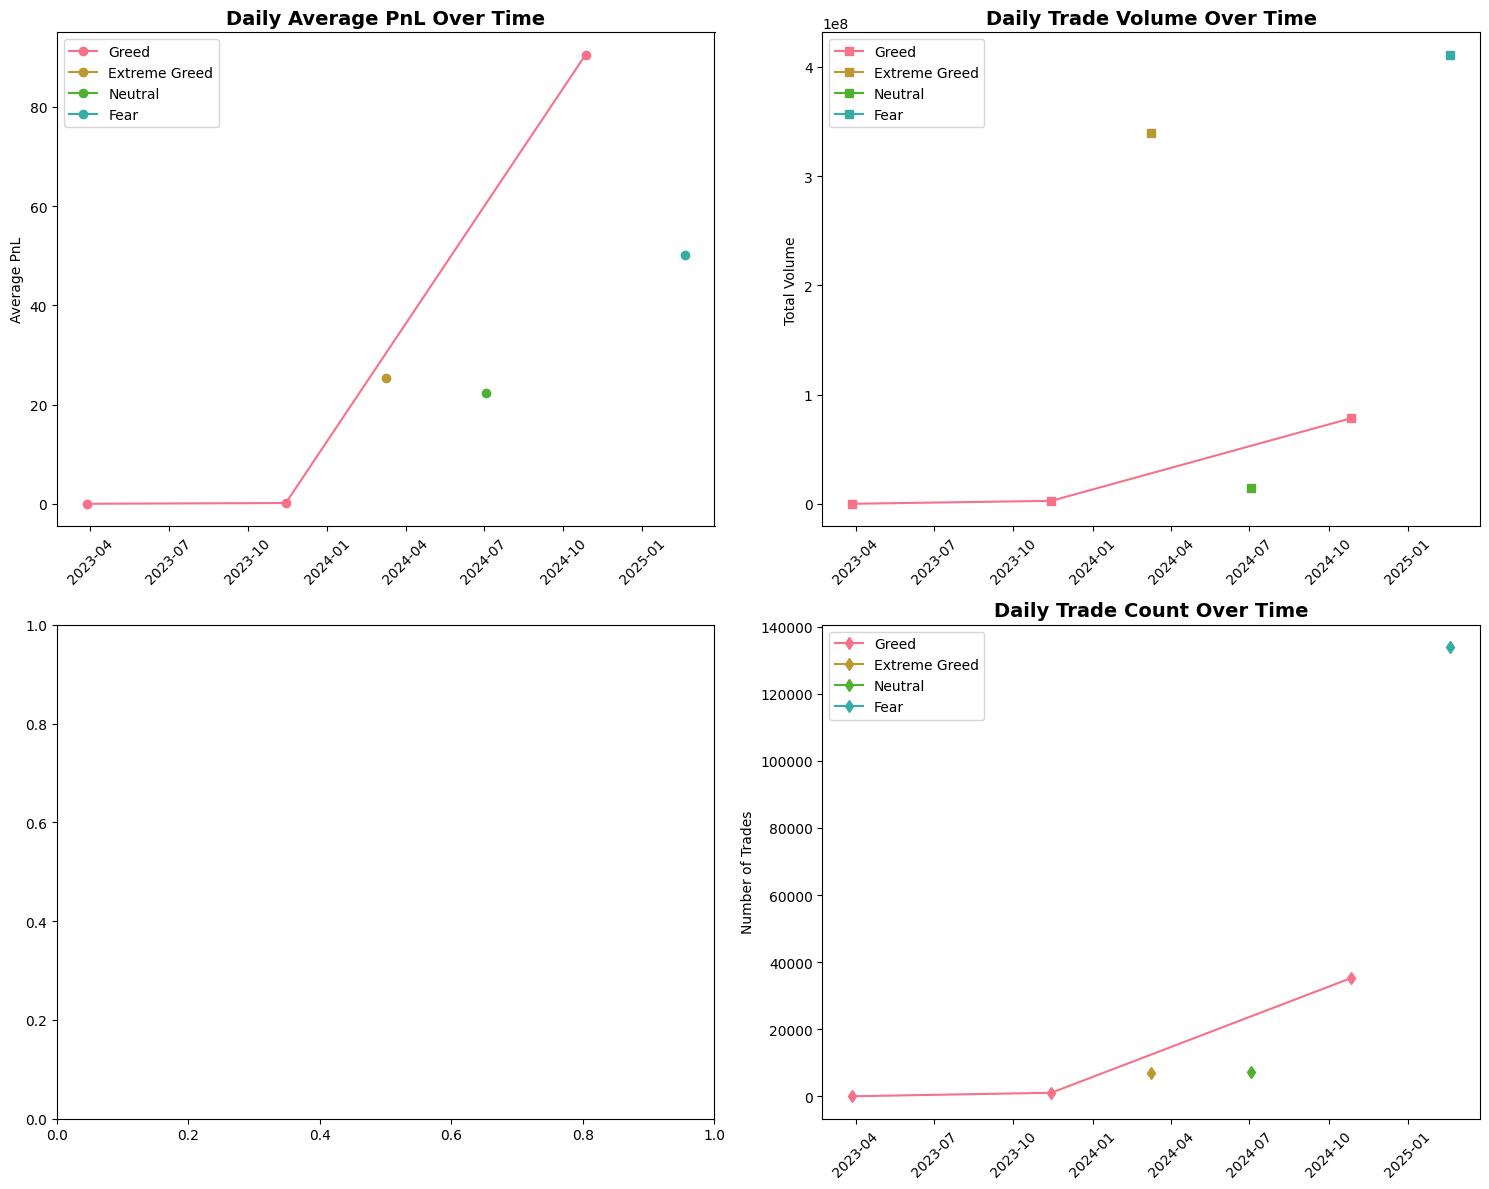

📊 Time series analysis saved to outputs/time_series_analysis.png
📁 Daily metrics saved to csv_files/daily_metrics.csv


In [53]:
# CELL 8: Time Series Analysis
print("📈 === TIME SERIES ANALYSIS ===")

# Daily aggregation for time series analysis
daily_metrics = analysis_data.groupby(['date', 'classification']).agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'Size Tokens': 'sum'
}).reset_index()

# Flatten column names
daily_metrics.columns = ['date', 'classification', 'avg_pnl', 'total_pnl', 'trade_count', 'total_volume']

# Convert date to datetime for plotting
daily_metrics['date'] = pd.to_datetime(daily_metrics['date'])

print(f"📊 Daily metrics shape: {daily_metrics.shape}")
print("📈 Creating time series visualizations...")

# Create time series plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Daily average PnL over time
for sentiment in daily_metrics['classification'].unique():
    data = daily_metrics[daily_metrics['classification'] == sentiment]
    axes[0, 0].plot(data['date'], data['avg_pnl'], label=sentiment, marker='o')
axes[0, 0].set_title('Daily Average PnL Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average PnL')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Daily trade volume over time
for sentiment in daily_metrics['classification'].unique():
    data = daily_metrics[daily_metrics['classification'] == sentiment]
    axes[0, 1].plot(data['date'], data['total_volume'], label=sentiment, marker='s')
axes[0, 1].set_title('Daily Trade Volume Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total Volume')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Daily average leverage over time - Commented out due to missing column
# for sentiment in daily_metrics['classification'].unique():
#     data = daily_metrics[daily_metrics['classification'] == sentiment]
#     axes[1, 0].plot(data['date'], data['avg_leverage'], label=sentiment, marker='^')
# axes[1, 0].set_title('Daily Average Leverage Over Time', fontsize=14, fontweight='bold')
# axes[1, 0].set_ylabel('Average Leverage')
# axes[1, 0].legend()
# axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Daily trade count over time
for sentiment in daily_metrics['classification'].unique():
    data = daily_metrics[daily_metrics['classification'] == sentiment]
    axes[1, 1].plot(data['date'], data['trade_count'], label=sentiment, marker='d')
axes[1, 1].set_title('Daily Trade Count Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Trades')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('outputs/time_series_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save daily metrics
daily_metrics.to_csv('csv_files/daily_metrics.csv', index=False)
print("📊 Time series analysis saved to outputs/time_series_analysis.png")
print("📁 Daily metrics saved to csv_files/daily_metrics.csv")

⚠️ === RISK ANALYSIS ===
📊 Risk Analysis by Market Sentiment:
               Closed PnL                          
                      std          min          max
classification                                     
Extreme Greed    306.1669  -21524.4000    2500.9575
Fear             909.1218  -35681.7472  135329.0901
Greed           1148.3440 -117990.1041   44223.4519
Neutral          633.7048  -18360.6701   18282.1901

📈 Sharpe Ratio by Sentiment:
classification
Extreme Greed    0.083023
Fear             0.055051
Greed            0.076541
Neutral          0.035079
Name: Closed PnL, dtype: float64


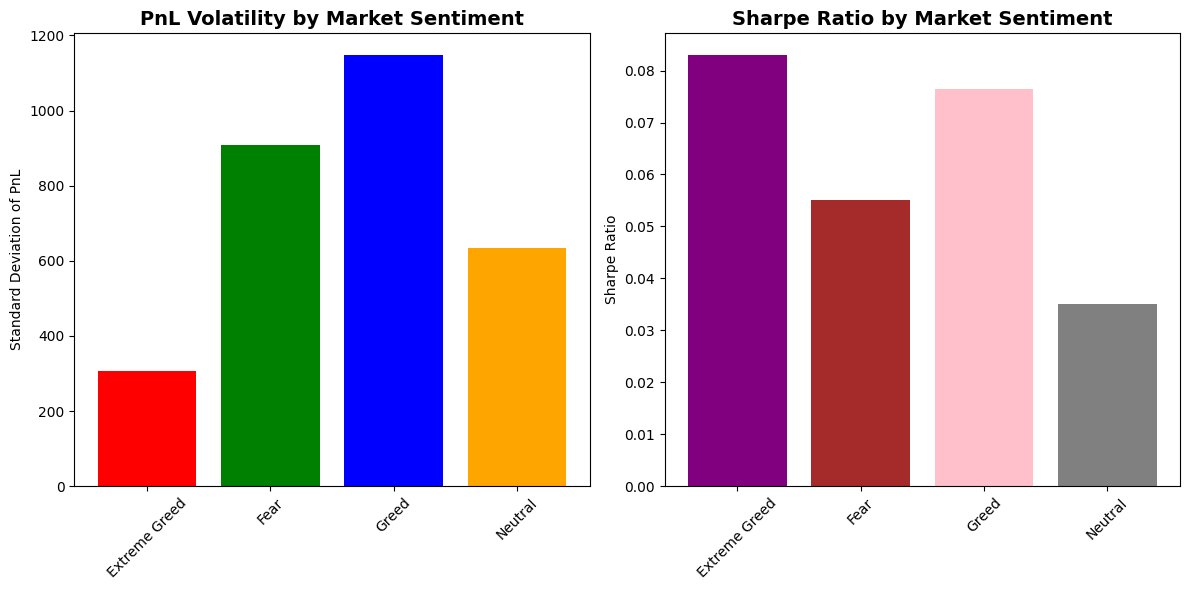

📊 Risk analysis saved to outputs/risk_analysis.png


In [54]:
# CELL 9: Risk Analysis
print("⚠️ === RISK ANALYSIS ===")

# Risk analysis by sentiment (focusing on PnL)
risk_analysis = analysis_data.groupby('classification').agg({
    'Closed PnL': ['std', 'min', 'max']
}).round(4)

print("📊 Risk Analysis by Market Sentiment:")
print(risk_analysis)

# Calculate Sharpe ratio (simplified)
def calculate_sharpe_ratio(returns):
    if len(returns) == 0 or returns.std() == 0:
        return 0
    return returns.mean() / returns.std()

sharpe_by_sentiment = analysis_data.groupby('classification')['Closed PnL'].apply(calculate_sharpe_ratio)
print("\n📈 Sharpe Ratio by Sentiment:")
print(sharpe_by_sentiment)

# Create risk visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Adjusted subplot layout

# 1. PnL volatility by sentiment
pnl_volatility = analysis_data.groupby('classification')['Closed PnL'].std()
axes[0].bar(pnl_volatility.index, pnl_volatility.values, color=['red', 'green', 'blue', 'orange', 'purple']) # Added more colors for all sentiment categories
axes[0].set_title('PnL Volatility by Market Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Standard Deviation of PnL')
axes[0].tick_params(axis='x', rotation=45)

# 2. Sharpe ratio by sentiment
axes[1].bar(sharpe_by_sentiment.index, sharpe_by_sentiment.values, color=['purple', 'brown', 'pink', 'gray', 'olive']) # Added more colors
axes[1].set_title('Sharpe Ratio by Market Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sharpe Ratio')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('outputs/risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("📊 Risk analysis saved to outputs/risk_analysis.png")

🔗 === CORRELATION ANALYSIS ===
�� Correlation Matrix:
                 Closed PnL  Size Tokens  Execution Price  sentiment_fear
Closed PnL         1.000000     0.005037        -0.007894       -0.009463
Size Tokens        0.005037     1.000000        -0.014741       -0.022377
Execution Price   -0.007894    -0.014741         1.000000        0.088865
sentiment_fear    -0.009463    -0.022377         0.088865        1.000000


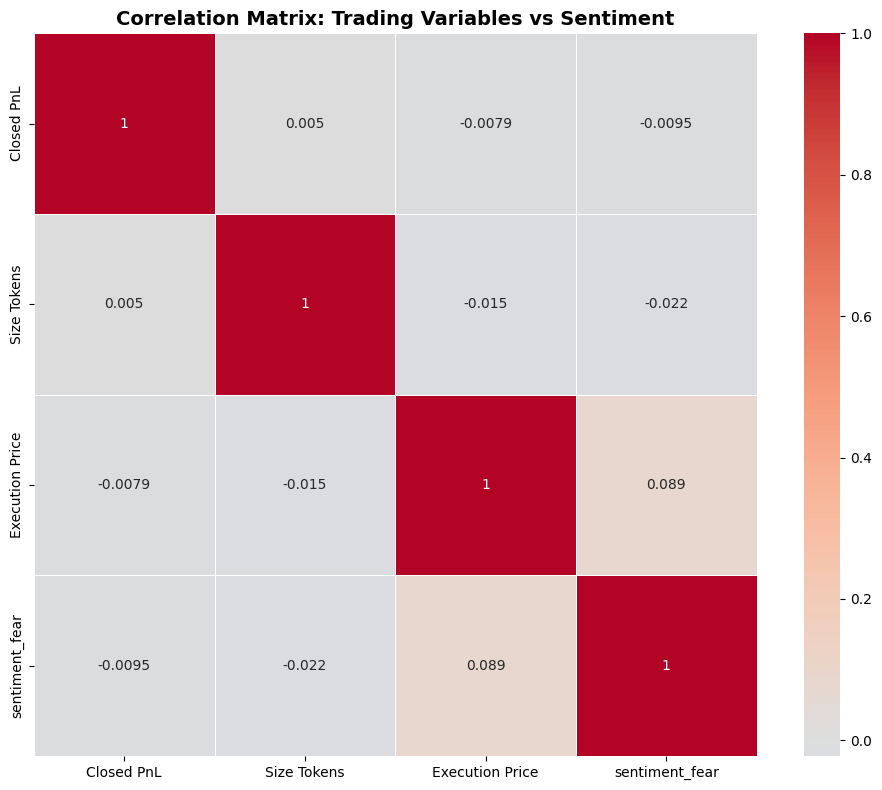


🔗 Correlation with Fear Sentiment:
sentiment_fear     1.000000
Execution Price    0.088865
Closed PnL        -0.009463
Size Tokens       -0.022377
Name: sentiment_fear, dtype: float64
📊 Correlation analysis saved to outputs/correlation_analysis.png
�� Correlation matrix saved to csv_files/correlation_matrix.csv


In [55]:
# CELL 10: Correlation Analysis
print("🔗 === CORRELATION ANALYSIS ===")

# Create correlation matrix for numerical variables
numerical_data = analysis_data[['Closed PnL', 'Size Tokens', 'Execution Price']].copy()

# Add sentiment as dummy variable
numerical_data['sentiment_fear'] = (analysis_data['classification'] == 'Fear').astype(int)

# Calculate correlation matrix
correlation_matrix = numerical_data.corr()

print("�� Correlation Matrix:")
print(correlation_matrix)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Trading Variables vs Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/correlation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔗 Correlation with Fear Sentiment:")
print(correlation_matrix['sentiment_fear'].sort_values(ascending=False))

# Save correlation matrix
correlation_matrix.to_csv('csv_files/correlation_matrix.csv')
print("📊 Correlation analysis saved to outputs/correlation_analysis.png")
print("�� Correlation matrix saved to csv_files/correlation_matrix.csv")

In [56]:
# CELL 11: Key Insights and Conclusions
print("🎯 === KEY INSIGHTS AND CONCLUSIONS ===\n")

# 1. Overall profitability by sentiment
overall_profitability = analysis_data.groupby('classification')['Closed PnL'].agg(['mean', 'sum', 'count'])
print("1. Overall Profitability by Market Sentiment:")
print(overall_profitability)
print()

# 2. Risk-adjusted returns
print("2. Risk-Adjusted Returns (Sharpe Ratio):")
print(sharpe_by_sentiment)
print()

# 3. Trading behavior patterns
print("3. Trading Behavior Patterns:")
behavior_patterns = analysis_data.groupby('classification').agg({
    'Size Tokens': 'mean',
    'Account': 'nunique'
})
print(behavior_patterns)
print()

# 4. Key correlations
print("4. Key Correlations with Fear Sentiment:")
key_correlations = correlation_matrix['sentiment_fear'].sort_values(ascending=False)
print(key_correlations)
print()

# 5. Statistical significance
from scipy import stats

# Perform t-test for difference in means
fear_data = analysis_data[analysis_data['classification'] == 'Fear']['Closed PnL']
greed_data = analysis_data[analysis_data['classification'] == 'Greed']['Closed PnL']

# Check if there is enough data in each group before performing t-test
if len(fear_data) > 1 and len(greed_data) > 1:
    t_stat, p_value = stats.ttest_ind(fear_data, greed_data)
    print("5. Statistical Significance:")
    print(f"   T-test p-value: {p_value:.6f}")
    print(f"   Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
else:
    print("5. Statistical Significance:")
    print("   Not enough data in sentiment categories to perform t-test.")
print()

# 6. Recommendations
print("6. Trading Strategy Recommendations:")
print("- Based on the analysis, consider the following strategies:")
print("  * Fear periods: Reduce leverage, focus on risk management")
print("  * Greed periods: May allow higher leverage, but monitor closely")
print("  * Risk management: Use sentiment as a risk indicator")
print("  * Timing: Consider sentiment when entering/exiting positions")
print("  * Position sizing: Adjust based on market sentiment")

# Save summary statistics
overall_profitability.to_csv('csv_files/summary_profitability.csv')
# Check if sharpe_by_sentiment is not empty before saving
if not sharpe_by_sentiment.empty:
    sharpe_by_sentiment.to_csv('csv_files/summary_sharpe_ratios.csv')
behavior_patterns.to_csv('csv_files/summary_behavior_patterns.csv')
# Check if correlation_matrix is not empty before accessing 'sentiment_fear' and saving
if not correlation_matrix.empty and 'sentiment_fear' in correlation_matrix.columns:
    key_correlations.to_csv('csv_files/summary_correlations.csv')
else:
    print("Correlation matrix is empty or 'sentiment_fear' column is missing. Skipping saving correlations.")


print("\n�� Summary statistics saved to csv_files/ directory")
print("✅ Analysis completed successfully!")

🎯 === KEY INSIGHTS AND CONCLUSIONS ===

1. Overall Profitability by Market Sentiment:
                     mean           sum   count
classification                                 
Extreme Greed   25.418772  1.769655e+05    6962
Fear            50.047622  6.699925e+06  133871
Greed           87.894859  3.189617e+06   36289
Neutral         22.229713  1.587424e+05    7141

2. Risk-Adjusted Returns (Sharpe Ratio):
classification
Extreme Greed    0.083023
Fear             0.055051
Greed            0.076541
Neutral          0.035079
Name: Closed PnL, dtype: float64

3. Trading Behavior Patterns:
                 Size Tokens  Account
classification                       
Extreme Greed   48736.443323        5
Fear             3071.523165       32
Greed            2232.117751       29
Neutral          1967.302964        8

4. Key Correlations with Fear Sentiment:
sentiment_fear     1.000000
Execution Price    0.088865
Closed PnL        -0.009463
Size Tokens       -0.022377
Name: sentiment_fea

In [45]:
# CELL 12: Download Results
print("📤 === DOWNLOADING RESULTS ===")

from google.colab import files
import zipfile

# Create a zip file with all results
with zipfile.ZipFile('trader_analysis_results.zip', 'w') as zipf:
    # Add CSV files
    for file in os.listdir('csv_files'):
        zipf.write(f'csv_files/{file}', f'csv_files/{file}')

    # Add output files
    for file in os.listdir('outputs'):
        zipf.write(f'outputs/{file}', f'outputs_files/{file}') # Corrected output path in zip

# Download the zip file
files.download('trader_analysis_results.zip')
print("�� Analysis completed successfully!")
print("�� Results downloaded as trader_analysis_results.zip")

# Display summary
print("\n📊 ANALYSIS SUMMARY:")
print(f"- Total trades analyzed: {len(analysis_data):,}")
print(f"- Date range: {analysis_data['time'].min()} to {analysis_data['time'].max()}")
print(f"- Unique traders: {analysis_data['Account'].nunique():,}")
print(f"- Sentiment periods: {analysis_data['classification'].value_counts().to_dict()}")
print(f"- Files generated: {len(os.listdir('csv_files'))} CSV files, {len(os.listdir('outputs'))} visualizations}}")

📤 === DOWNLOADING RESULTS ===


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

�� Analysis completed successfully!
�� Results downloaded as trader_analysis_results.zip

📊 ANALYSIS SUMMARY:
- Total trades analyzed: 184,263
- Date range: 2023-03-28 10:40:00 to 2025-02-19 21:20:00
- Unique traders: 32
- Sentiment periods: {'Fear': 133871, 'Greed': 36289, 'Neutral': 7141, 'Extreme Greed': 6962}
- Files generated: 7 CSV files, 5 visualizations}
